In [1]:
# Essentials
import os, sys, glob
import pandas as pd
import numpy as np
import nibabel as nib
import scipy.io as sio
from tqdm import tqdm

# Stats
import scipy as sp
from scipy import stats
import statsmodels.api as sm
import pingouin as pg

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
from brainspace.datasets import load_group_fc, load_parcellation, load_conte69
from brainspace.plotting import plot_hemispheres
from brainspace.gradient import GradientMaps
from brainspace.utils.parcellation import map_to_labels
from brainspace.gradient.utils import dominant_set

/Users/lindenmp/opt/anaconda3/envs/pfactor_gradients/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.9, the latest is 0.3.10.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
sys.path.append('/Users/lindenmp/Google-Drive-Penn/work/research_projects/pfactor_gradients/1_code/')
from func import set_proj_env, my_regplot, bandpower, get_rlfp

In [4]:
parc_str = 'schaefer' # 'schaefer' 'lausanne' 'glasser'
parc_scale = 400 # 200/400 | 125/250 | 360
edge_weight = 'streamlineCount' # 'streamlineCount' 'volNormStreamline'
set_proj_env()

('/Users/lindenmp/Google-Drive-Penn/work/research_projects/pfactor_gradients',
 '/Users/lindenmp/Google-Drive-Penn/work/research_projects/pfactor_gradients/0_data',
 '/Volumes/work_ssd/research_data/PNC/',
 '/Users/lindenmp/Google-Drive-Penn/work/research_projects/pfactor_gradients/2_pipeline',
 '/Users/lindenmp/Google-Drive-Penn/work/research_projects/pfactor_gradients/3_output')

In [5]:
# output file prefix
outfile_prefix = parc_str+'_'+str(parc_scale)+'_'+edge_weight+'_'
outfile_prefix

'schaefer_400_streamlineCount_'

In [6]:
# Parcellation specifications
if parc_str == 'schaefer':
    # Names of parcels
    parcel_names = np.genfromtxt(os.path.join(os.environ['PROJDIR'], 'figs_support/labels/schaefer' + str(parc_scale) + 'NodeNames.txt'), dtype='str')
    num_parcels = parcel_names.shape[0]
    
    rstsdir = os.path.join(os.environ['DERIVSDIR'], 'processedData/restbold/restbold_201607151621')
    if parc_scale == 200:
        rsts_name_tmp = 'bblid/*xscanid/net/Schaefer' + str(parc_scale) + 'PNC/bblid_*xscanid_Schaefer' + str(parc_scale) + 'PNC_ts.1D'
        alff_name_tmp = 'bblid/*xscanid/alff/roi/Schaefer' + str(parc_scale) + 'PNC/bblid_*xscanid_Schaefer' + str(parc_scale) + 'PNC_val_alff.1D'
        reho_name_tmp = 'bblid/*xscanid/reho/roi/Schaefer' + str(parc_scale) + 'PNC/bblid_*xscanid_Schaefer' + str(parc_scale) + 'PNC_val_reho.1D'
    elif parc_scale == 400:
        rsts_name_tmp = 'bblid/*xscanid/net/SchaeferPNC/bblid_*xscanid_SchaeferPNC_ts.1D'
        alff_name_tmp = 'bblid/*xscanid/alff/roi/SchaeferPNC/bblid_*xscanid_SchaeferPNC_val_alff.1D'
        reho_name_tmp = 'bblid/*xscanid/reho/roi/SchaeferPNC/bblid_*xscanid_SchaeferPNC_val_reho.1D'
elif parc_str == 'glasser':
    parcel_names = np.genfromtxt(os.path.join(os.environ['PROJDIR'], 'figs_support/labels/glasser' + str(parc_scale) + 'NodeNames.txt'), dtype='str')
    num_parcels = parcel_names.shape[0]

    rstsdir = os.path.join(os.environ['DERIVSDIR'], 'processedData/restbold/restbold_201607151621')
    rsts_name_tmp = 'bblid/*xscanid/net/GlasserPNC/bblid_*xscanid_GlasserPNC_ts.1D'
    alff_name_tmp = 'bblid/*xscanid/alff/roi/GlasserPNC/bblid_*xscanid_GlasserPNC_val_alff.1D'
    reho_name_tmp = 'bblid/*xscanid/reho/roi/GlasserPNC/bblid_*xscanid_GlasserPNC_val_reho.1D'    

### Setup directory variables

In [7]:
print(os.environ['PIPELINEDIR'])
if not os.path.exists(os.environ['PIPELINEDIR']): os.makedirs(os.environ['PIPELINEDIR'])

/Users/lindenmp/Google-Drive-Penn/work/research_projects/pfactor_gradients/2_pipeline


In [8]:
outputdir = os.path.join(os.environ['PIPELINEDIR'], '1_compute_gradient', 'out')
print(outputdir)
if not os.path.exists(outputdir): os.makedirs(outputdir)

/Users/lindenmp/Google-Drive-Penn/work/research_projects/pfactor_gradients/2_pipeline/1_compute_gradient/out


In [9]:
figdir = os.path.join(os.environ['OUTPUTDIR'], 'figs')
print(figdir)
if not os.path.exists(figdir): os.makedirs(figdir)

/Users/lindenmp/Google-Drive-Penn/work/research_projects/pfactor_gradients/3_output/figs


## Load data

In [10]:
# Load data
df = pd.read_csv(os.path.join(os.environ['PIPELINEDIR'], '0_get_sample', 'out', outfile_prefix+'df_gradients.csv'))
df.set_index(['bblid', 'scanid'], inplace = True)
# retain discovery sample only
# df = df.loc[df['disc_repl'] == 0,:]
print(df.shape)

(775, 56)


In [11]:
df['ageAtScan1_Years'].mean()

15.716903225806453

In [12]:
df['ageAtScan1_Years'].std()

3.312650672842933

In [13]:
num_subs = df.shape[0]; print(num_subs)
num_time = 120

num_connections = num_parcels * (num_parcels - 1) / 2; print(num_connections)

775
79800.0


## Load in time series, compute FC

In [14]:
# subject filter
subj_filt = np.zeros((df.shape[0],)).astype(bool)

In [15]:
# fc stored as 3d matrix, subjects of 3rd dim
fc = np.zeros((num_parcels, num_parcels, num_subs))
rlfp = np.zeros((num_subs, num_parcels))

for (i, (index, row)) in enumerate(df.iterrows()):
    file_name = rsts_name_tmp.replace("bblid", str(index[0]))
    file_name = file_name.replace("scanid", str(index[1]))
    full_path = glob.glob(os.path.join(rstsdir, file_name))
    if i == 0: print(full_path)
        
    if len(full_path) > 0:
        roi_ts = np.loadtxt(full_path[0])
        fc[:,:,i] = np.corrcoef(roi_ts, rowvar = False)
        # fisher r to z
        fc[:,:,i] = np.arctanh(fc[:,:,i])
        np.fill_diagonal(fc[:,:,i], 1)
        
        for j in np.arange(num_parcels):
            rlfp[i,j] = get_rlfp(roi_ts[:,j], tr = 3, num_bands = 5, band_of_interest = 1)

        if np.any(np.isnan(fc[:,:,i])):
            subj_filt[i] = True

    elif len(full_path) == 0:
        print(file_name + ': NOT FOUND')
        subj_filt[i] = True
        roi_ts[:,:,i] = np.full((num_time, num_parcels), np.nan)
        fc[:,:,i] = np.full((num_parcels, num_parcels), np.nan)
        rlfp[i,:] = np.full(num_parcels, np.nan)

['/Volumes/work_ssd/research_data/PNC/processedData/restbold/restbold_201607151621/81287/20100114x2738/net/SchaeferPNC/81287_20100114x2738_SchaeferPNC_ts.1D']


/Users/lindenmp/opt/anaconda3/envs/pfactor_gradients/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in arctanh
  from ipykernel import kernelapp as app


## Load in bold properties

In [16]:
alff = np.zeros((num_subs, num_parcels))
reho = np.zeros((num_subs, num_parcels))

for (i, (index, row)) in enumerate(df.iterrows()):
    file_name = alff_name_tmp.replace("bblid", str(index[0]))
    file_name = file_name.replace("scanid", str(index[1]))
    full_path = glob.glob(os.path.join(rstsdir, file_name))
    if i == 0: print(full_path)
    alff[i,:] = np.loadtxt(full_path[0], skiprows = 1, usecols = np.arange(2,num_parcels+2))
    if np.any(np.isnan(alff[i,:])):
        subj_filt[i] = True
            
    file_name = reho_name_tmp.replace("bblid", str(index[0]))
    file_name = file_name.replace("scanid", str(index[1]))
    full_path = glob.glob(os.path.join(rstsdir, file_name))
    if i == 0: print(full_path)
    reho[i,:] = np.loadtxt(full_path[0], skiprows = 1, usecols = np.arange(2,num_parcels+2))
    if np.any(np.isnan(reho[i,:])):
        subj_filt[i] = True

['/Volumes/work_ssd/research_data/PNC/processedData/restbold/restbold_201607151621/81287/20100114x2738/alff/roi/SchaeferPNC/81287_20100114x2738_SchaeferPNC_val_alff.1D']
['/Volumes/work_ssd/research_data/PNC/processedData/restbold/restbold_201607151621/81287/20100114x2738/reho/roi/SchaeferPNC/81287_20100114x2738_SchaeferPNC_val_reho.1D']


In [17]:
np.sum(subj_filt)

0

In [18]:
if any(subj_filt):
    df = df.loc[~subj_filt]
    fc = fc[:,:,~subj_filt]
    alff = alff[~subj_filt,:]
    reho = reho[~subj_filt,:]
    rlfp = rlfp[~subj_filt,:]

### Save out FC and bold metrics

In [19]:
np.save(os.path.join(outputdir, outfile_prefix+'fc'),fc)
np.save(os.path.join(outputdir, outfile_prefix+'rlfp'),rlfp)
np.save(os.path.join(outputdir, outfile_prefix+'alff'),alff)
np.save(os.path.join(outputdir, outfile_prefix+'reho'),reho)

In [20]:
np.save(os.path.join(outputdir, outfile_prefix+'fc_disc'),fc[:,:,df['disc_repl'] == 0])
np.save(os.path.join(outputdir, outfile_prefix+'rlfp_disc'),rlfp[df['disc_repl'] == 0,:])
np.save(os.path.join(outputdir, outfile_prefix+'alff_disc'),alff[df['disc_repl'] == 0,:])
np.save(os.path.join(outputdir, outfile_prefix+'reho_disc'),reho[df['disc_repl'] == 0,:])

In [21]:
np.save(os.path.join(outputdir, outfile_prefix+'fc_repl'),fc[:,:,df['disc_repl'] == 1])
np.save(os.path.join(outputdir, outfile_prefix+'rlfp_repl'),rlfp[df['disc_repl'] == 1,:])
np.save(os.path.join(outputdir, outfile_prefix+'alff_repl'),alff[df['disc_repl'] == 1,:])
np.save(os.path.join(outputdir, outfile_prefix+'reho_repl'),reho[df['disc_repl'] == 1,:])

### Generate participant gradients

In [22]:
# Generate template
pnc_conn_mat = np.nanmean(fc, axis = 2)
pnc_conn_mat[np.eye(num_parcels, dtype = bool)] = 0
# pnc_conn_mat = dominant_set(pnc_conn_mat, 0.10, as_sparse = False)

gm_template = GradientMaps(n_components = 2, approach='dm', kernel=None, random_state = 0)
# gm_template = GradientMaps(n_components = 2, approach='dm', kernel='normalized_angle', random_state = 0)
# gm_template = GradientMaps(n_components = 2, approach='dm', kernel='pearson', random_state = 0)
# gm_template = GradientMaps(n_components = 2, approach='dm', kernel='cosine', random_state = 0)
# gm_template = GradientMaps(n_components = 2, approach='dm', kernel='spearman', random_state = 0)
gm_template.fit(pnc_conn_mat)

if parc_scale == 200:
    gm_template.gradients_ = gm_template.gradients_ * -1
    gradients = np.zeros(gm_template.gradients_.shape)
    gradients[:,0], gradients[:,1] = gm_template.gradients_[:,1], gm_template.gradients_[:,0]
elif parc_scale == 400:
    gradients = np.zeros(gm_template.gradients_.shape)
    gradients[:,0], gradients[:,1] = gm_template.gradients_[:,1] * -1, gm_template.gradients_[:,0]
else:
    gm_template.gradients_ = gm_template.gradients_ * -1
    gradients = np.zeros(gm_template.gradients_.shape)
    gradients[:,0], gradients[:,1] = gm_template.gradients_[:,1], gm_template.gradients_[:,0]

np.savetxt(os.path.join(outputdir,outfile_prefix+'pnc_grads_template.txt'),gradients)

/Users/lindenmp/opt/anaconda3/envs/pfactor_gradients/lib/python3.7/site-packages/brainspace/gradient/embedding.py:70: UserWarning: Affinity is not symmetric. Making symmetric.
  warnings.warn('Affinity is not symmetric. Making symmetric.')


# Plots

In [23]:
if not os.path.exists(figdir): os.makedirs(figdir)
os.chdir(figdir)
sns.set(style='white', context = 'talk', font_scale = 1)

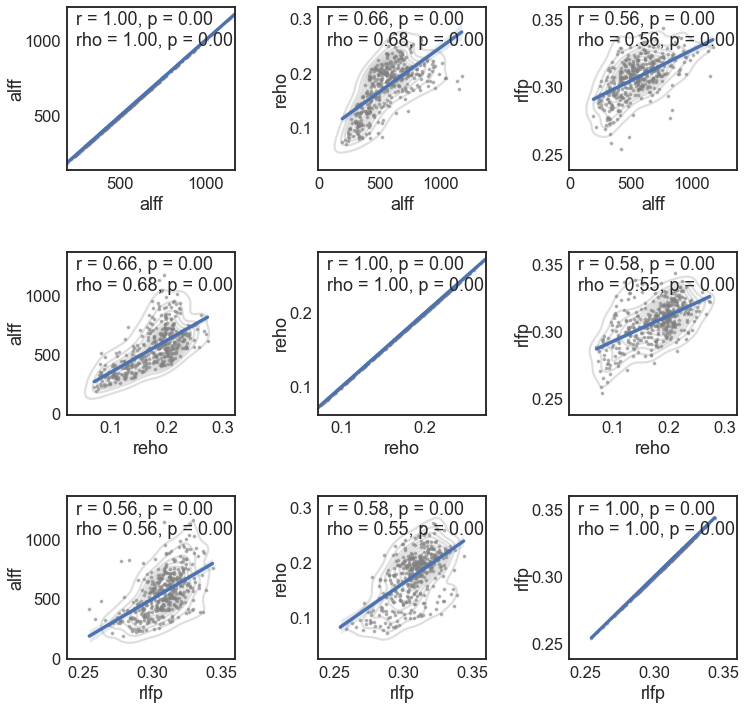

In [24]:
f, ax = plt.subplots(3, 3, figsize=(12, 12))
var_list = [alff, reho, rlfp]
var_labels = ['alff', 'reho', 'rlfp']
for i in np.arange(3):
    for j in np.arange(3):
        my_regplot(np.mean(var_list[i], axis = 0), np.mean(var_list[j], axis = 0), var_labels[i], var_labels[j], ax[i,j])
    
f.subplots_adjust(wspace=0.5, hspace=0.5)

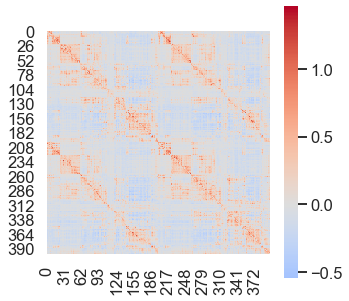

In [25]:
f, ax = plt.subplots(1, figsize=(5, 5))
sns.heatmap(pnc_conn_mat, cmap = 'coolwarm', center = 0, square = True)
f.savefig(outfile_prefix+'mean_fc.png', dpi = 300, bbox_inches = 'tight')

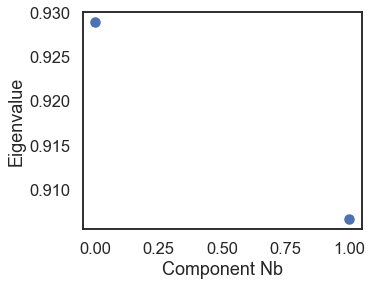

In [26]:
f, ax = plt.subplots(1, figsize=(5, 4))
ax.scatter(range(gm_template.lambdas_.size), gm_template.lambdas_)
ax.set_xlabel('Component Nb')
ax.set_ylabel('Eigenvalue')
f.savefig(outfile_prefix+'gradient_eigenvals.png', dpi = 300, bbox_inches = 'tight')

In [27]:
from func import roi_to_vtx
from nilearn import datasets
from nilearn import plotting
# if parc_str == 'schaefer':
#     atlas = datasets.fetch_atlas_schaefer_2018(n_rois=parc_scale, yeo_networks=17, resolution_mm=2)
# parcellation = atlas['maps']
if parc_str == 'schaefer':
    fsaverage = datasets.fetch_surf_fsaverage(mesh='fsaverage5')
elif parc_str == 'glasser':
    fsaverage = datasets.fetch_surf_fsaverage(mesh='fsaverage')

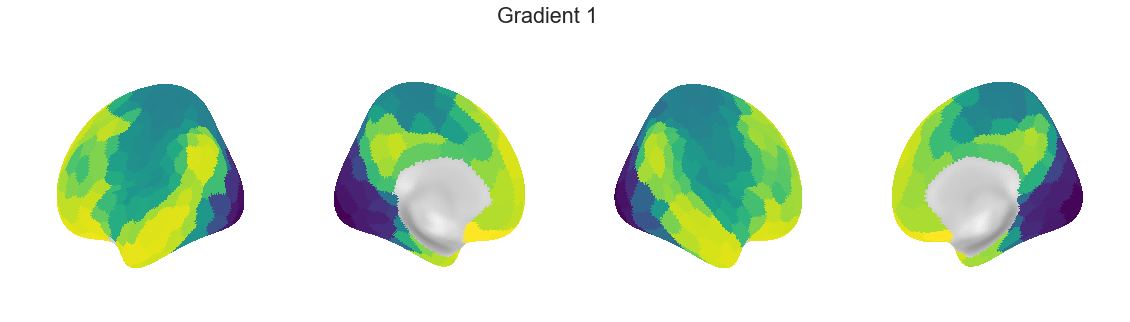

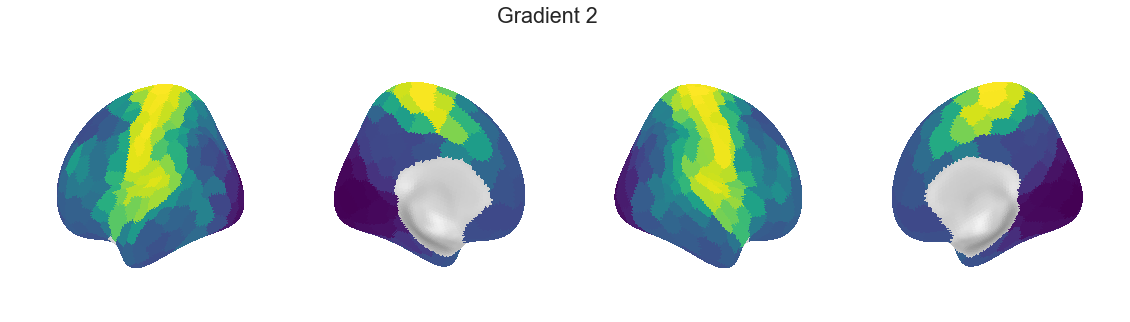

In [28]:
for g in np.arange(0,2):
    f, ax = plt.subplots(1, 4, figsize=(20, 5), subplot_kw={'projection': '3d'})
    plt.subplots_adjust(wspace=0, hspace=0)

    if parc_str == 'schaefer':
        parc_file = os.path.join(os.environ['PROJDIR'],'figs_support/Parcellations/FreeSurfer5.3/fsaverage5/label/lh.Schaefer2018_'+str(parc_scale)+'Parcels_17Networks_order.annot')
    elif parc_str == 'glasser':
        parc_file = os.path.join(os.environ['PROJDIR'],'figs_support/Parcellations/FreeSurfer5.3/fsaverage/label/lh.HCP-MMP1.annot')
    
    labels, ctab, surf_names = nib.freesurfer.read_annot(parc_file)
    vtx_data, plot_min, plot_max = roi_to_vtx(gradients[:,g], parcel_names, parc_file)
    vtx_data = vtx_data.astype(float)
    plotting.plot_surf_roi(fsaverage['infl_left'], roi_map=vtx_data,
                           hemi='left', view='lateral', vmin=plot_min, vmax=plot_max,
                           bg_map=fsaverage['sulc_left'], bg_on_data=False, axes=ax[0],
                           darkness=.5, cmap='viridis');

    plotting.plot_surf_roi(fsaverage['infl_left'], roi_map=vtx_data,
                           hemi='left', view='medial', vmin=plot_min, vmax=plot_max,
                           bg_map=fsaverage['sulc_left'], bg_on_data=False, axes=ax[1],
                           darkness=.5, cmap='viridis');

    if parc_str == 'schaefer':
        parc_file = os.path.join(os.environ['PROJDIR'],'figs_support/Parcellations/FreeSurfer5.3/fsaverage5/label/rh.Schaefer2018_'+str(parc_scale)+'Parcels_17Networks_order.annot')
    elif parc_str == 'glasser':
        parc_file = os.path.join(os.environ['PROJDIR'],'figs_support/Parcellations/FreeSurfer5.3/fsaverage/label/rh.HCP-MMP1.annot')

    labels, ctab, surf_names = nib.freesurfer.read_annot(parc_file)
    vtx_data, plot_min, plot_max = roi_to_vtx(gradients[:,g], parcel_names, parc_file)
    vtx_data = vtx_data.astype(float)
    plotting.plot_surf_roi(fsaverage['infl_right'], roi_map=vtx_data,
                           hemi='right', view='lateral', vmin=plot_min, vmax=plot_max,
                           bg_map=fsaverage['sulc_right'], bg_on_data=False, axes=ax[2],
                           darkness=.5, cmap='viridis');

    plotting.plot_surf_roi(fsaverage['infl_right'], roi_map=vtx_data,
                           hemi='right', view='medial', vmin=plot_min, vmax=plot_max,
                           bg_map=fsaverage['sulc_right'], bg_on_data=False, axes=ax[3],
                           darkness=.5, cmap='viridis');

    f.suptitle('Gradient '+str(g+1))
    f.savefig(outfile_prefix+'gradient_'+str(g)+'.png', dpi = 150, bbox_inches = 'tight', pad_inches = 0)

# Setup gradient sampling for NCT

20
[58 17 14 16 17 10 17 37 19 32 19 29 11 30  7  7 10 23  7 20]


Text(0, 0.5, 'Gradient 1')

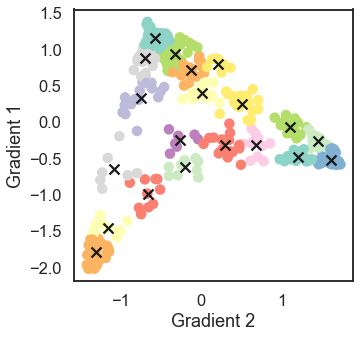

In [29]:
from sklearn.cluster import KMeans

n_clusters=int(num_parcels*.05)
print(n_clusters)

kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(gradients)
colormask = kmeans.labels_

unique, counts = np.unique(kmeans.labels_, return_counts = True)
print(counts)

f, ax = plt.subplots(figsize=(5, 5))
ax.scatter(gradients[:,1], gradients[:,0], c = colormask, cmap= 'Set3')
ax.scatter(kmeans.cluster_centers_[:,1], kmeans.cluster_centers_[:,0], marker = 'x', c = 'k', s = 100)
ax.set_xlabel('Gradient 2')
ax.set_ylabel('Gradient 1')

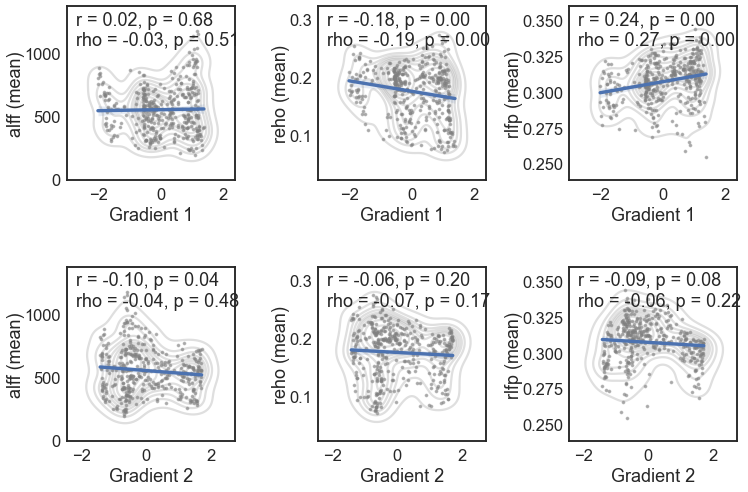

In [30]:
f, ax = plt.subplots(2, 3, figsize=(12, 8))
my_regplot(gradients[:,0], np.mean(alff, axis = 0), 'Gradient 1', 'alff (mean)', ax[0,0])
my_regplot(gradients[:,0], np.mean(reho, axis = 0), 'Gradient 1', 'reho (mean)', ax[0,1])
my_regplot(gradients[:,0], np.mean(rlfp, axis = 0), 'Gradient 1', 'rlfp (mean)', ax[0,2])

my_regplot(gradients[:,1], np.mean(alff, axis = 0), 'Gradient 2', 'alff (mean)', ax[1,0])
my_regplot(gradients[:,1], np.mean(reho, axis = 0), 'Gradient 2', 'reho (mean)', ax[1,1])
my_regplot(gradients[:,1], np.mean(rlfp, axis = 0), 'Gradient 2', 'rlfp (mean)', ax[1,2])

f.subplots_adjust(wspace=0.5, hspace=0.5)